In [2]:
deps_path = '/kaggle/input/h77777'
! pip install --no-index --find-links {deps_path} --requirement {deps_path}/requirements.txt

Looking in links: /kaggle/input/h77777
Processing /kaggle/input/h77777/dicomsdl-0.109.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (from -r /kaggle/input/h77777/requirements.txt (line 2))
Processing /kaggle/input/h77777/pylibjpeg-2.0.1-py3-none-any.whl (from -r /kaggle/input/h77777/requirements.txt (line 3))
Processing /kaggle/input/h77777/python_gdcm-3.0.24.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (from -r /kaggle/input/h77777/requirements.txt (line 4))


In [3]:
# Standard library imports
import os
import time

# Third-party library imports
import cv2
import pydicom
import dicomsdl

# Visualization library imports
import matplotlib.pyplot as plt

# Progress bar library imports
from tqdm.notebook import tqdm, trange

# Parallel processing library imports
from joblib import Parallel, delayed

import gc

import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_datasets as tfds
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import logging
import random
import pickle
import math

from kaggle_datasets import KaggleDatasets
from multiprocessing import cpu_count


In [4]:
class MammographyPreprocessor():
    
    # Constructor
    def __init__(self, size: tuple=None, breast_side: str='L',
                 csv_path=None, train_path=None):
        self.size = size
        os.makedirs(os.getcwd(), exist_ok=True)
        self.breast_side = breast_side
        assert breast_side in ['L', 'R'], "breast_side should be 'L' or 'R'"
        # implement the paths of the original RSNA dataset (V2)
        self.csv_path = '/kaggle/input/rsna-breast-cancer-detection/train.csv'
        self.train_path = '/kaggle/input/rsna-breast-cancer-detection/train_images'
        if csv_path:
            self.csv_path = csv_path
        if train_path:
            self.train_path = train_path
        self.df = pd.read_csv(self.csv_path)
        self.save_root = os.getcwd()
    
    # Get the paths from the preprocessor (V2)
    def get_paths(self, n: int=None, shuffle: bool=False, return_cache: bool=False):
        if n == None:
            n = len(self.df)
        if shuffle == True:
            df = self.df.sample(frac=1, random_state=0).copy()
        else:
            df = self.df.copy()
        paths = []
        ids_cache = []
        for i in range(n):
            patient = str(df.iloc[i]['patient_id'])
            scan = str(df.iloc[i]['image_id'])
            paths.append(self.train_path + '/' + patient + '/' + scan + '.dcm')
            ids_cache.append({'patient_id': patient, 'scan_id': scan})
        if return_cache:
            return paths, ids_cache
        else:
            return paths
    
    # Read from a path and convert to image array
    def read_image(self, path: str):
        scan = pydicom.dcmread(path)
        img = scan.pixel_array
        return img
    
    # Apply the preprocessing methods on one image
    def preprocess_single_image(self, path: str, save: bool=False,
                                save_dir: str=None, png: bool=True):
        scan = dicomsdl.open(path)
        img = scan.pixelData()
        #img = self._windowing(img, scan)
        img = self._fix_photometric_interpretation(img, scan)
        img = self._normalize_to_255(img)
        img = self._flip_breast_side(img)
        img = self._crop(img)
        if self.size:
            img = self._resize(img)
        if save:
            self._save_image(img, path, png, save_dir)
            return # do not return the images to avoid memory leak
        return img
    
    # Preprocess all the images from the paths
    def preprocess_all(self, paths: list, save: bool=True,
                       save_dir: str='train_images', png: bool=True,
                       parallel: bool=False, n_jobs: int=4):
        clock = time.time()
        if parallel:
            Parallel(n_jobs=n_jobs) \
            (delayed(self.preprocess_single_image) \
            (path, save, save_dir, png) for path in tqdm(paths, total=len(paths)))
            print("Parallel preprocessing done!")
        else:
            for i in trange(len(paths)):
                self.preprocess_single_image(paths[i], save, save_dir, png)
            print("Sequential preprocessing done!")
        print("Time =", np.around(time.time() - clock, 3), 'sec')
    '''
    # Display the images from the dicom paths with optional preprocessing
    def display(self, paths: list, rows: int, cols: int,
                preprocess: bool=False, cmap='bone', cbar: bool=False,
                save_fig: bool=False, save_name: str='myplot.png'):
        assert len(paths) >= (rows * cols), \
        f"Not enough paths for the display. " \
        f"Please give at least {rows * cols} paths."
        plt.figure(figsize=(18, 26 * rows / cols))
        for i in trange(rows * cols):
            path = paths[i]
            if preprocess:
                img = self.preprocess_single_image(path, save=False)
            else:
                img = self.read_image(path)
            plt.subplot(rows, cols, i+1)
            plt.imshow(img, cmap=cmap)
            if cbar:
                plt.colorbar()
            plt.grid(False)
            plt.title(path.split('/')[-1][:-4])
        plt.suptitle("Preprocessed images" if preprocess \
                     else "Raw images", fontsize=25)
        if save_fig:
            plt.savefig(save_name, facecolor='white')
        plt.show()'''
    
    # Adjust the contrast of an image
    def _windowing(self, img, scan):
        center = scan.WindowCenter
        width = scan.WindowWidth
        bits_stored = scan.BitsStored
        function = scan.VOILUTFunction
        if isinstance(center, list):
            center = center[0]
        if isinstance(width, list):
            width = width[0] 
        y_range = float(2**bits_stored - 1)
        if function == 'SIGMOID':
            img = y_range / (1 + np.exp(-4 * (img - center) / width))
        else: # LINEAR
            center -= 0.5
            width -= 1
            below = img <= (center - width / 2)
            above = img > (center + width / 2)
            between = np.logical_and(~below, ~above)
            img[below] = 0
            img[above] = y_range
            img[between] = ((img[between] - center) / width + 0.5) * y_range
        return img
    
    # Interpret pixels in a consistant way
    def _fix_photometric_interpretation(self, img, scan):
        if scan.PhotometricInterpretation == 'MONOCHROME1':
            return img.max() - img
        elif scan.PhotometricInterpretation == 'MONOCHROME2':
            return img - img.min()
        else:
            raise ValueError("Invalid Photometric Interpretation: {}"
                               .format(scan.PhotometricInterpretation))
    
    # Cast into 8-bits for saving
    def _normalize_to_255(self, img):
        if img.max() != 0:
            img = img / img.max()
        img *= 255
        return img.astype(np.uint8)
    
    # Flip the breast horizontally on the chosen side 
    def _flip_breast_side(self, img):
        img_breast_side = self._determine_breast_side(img)
        if img_breast_side == self.breast_side:
            return img
        else:
            return np.fliplr(img)    
    
    # Determine the current breast side
    def _determine_breast_side(self, img):
        col_sums_split = np.array_split(np.sum(img, axis=0), 2)
        left_col_sum = np.sum(col_sums_split[0])
        right_col_sum = np.sum(col_sums_split[1])
        if left_col_sum > right_col_sum:
            return 'L'
        else:
            return 'R'
    
    # Crop the useless background of the image
    def _crop(self, img):
        bin_img = self._binarize(img, threshold=5)
        contour = self._extract_contour(bin_img)
        img = self._erase_background(img, contour)
        x1, x2 = np.min(contour[:, :, 0]), np.max(contour[:, :, 0])
        y1, y2 = np.min(contour[:, :, 1]), np.max(contour[:, :, 1])
        x1, x2 = int(0.99 * x1), int(1.01 * x2)
        y1, y2 = int(0.99 * y1), int(1.01 * y2)
        return img[y1:y2, x1:x2]
    
    # Binarize the image at the threshold
    def _binarize(self, img, threshold):
        return (img > threshold).astype(np.uint8)
    
    # Get contour points of the breast
    def _extract_contour(self, bin_img):
        contours, _ = cv2.findContours(
            bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contour = max(contours, key=cv2.contourArea)
        return contour
    
    # Set to background pixels of the image to zero
    def _erase_background(self, img, contour):
        mask = np.zeros(img.shape, np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
        output = cv2.bitwise_and(img, mask)
        return output
    
    # Resize the image to the preprocessor size
    def _resize(self, img):
        return cv2.resize(img, self.size)
    
    # Get the save path of a given dicom file
    def _get_save_path(self, path, png, save_dir):
        patient = path.split('/')[-2]
        filename = path.split('/')[-1]
        if png:
            filename = filename.replace('dcm', 'png')
        else:
            filename = filename.replace('dcm', 'jpeg')
        if save_dir:
            save_path = os.path.join(self.save_root, save_dir, patient, filename)
        else:
            save_path = os.path.join(self.save_root, patient, filename)
        return save_path
    
    # Save the preprocessed image
    def _save_image(self, img, path, png, save_dir):
        save_path = self._get_save_path(path, png, save_dir)
        patient_folder = os.path.split(save_path)[0]
        os.makedirs(patient_folder, exist_ok=True)
        cv2.imwrite(save_path, img)

In [5]:
# Detect hardware, return appropriate distribution strategy
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', TPU.master())
except ValueError:
    print('Running on CPU or GPU')
    TPU = None

if TPU:
    IS_TPU = True
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    STRATEGY = tf.distribute.experimental.TPUStrategy(TPU)
else:
    IS_TPU = False
    STRATEGY = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

#clear_output()
N_REPLICAS = STRATEGY.num_replicas_in_sync
print(f'N_REPLICAS: {N_REPLICAS}, IS_TPU: {IS_TPU}')

Running on CPU or GPU
N_REPLICAS: 1, IS_TPU: False


In [6]:
# Image dimensions
IMG_HEIGHT = 1456
IMG_WIDTH = 728
N_CHANNELS = 1
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 1)
N_SAMPLES_TFRECORDS = 548

# Peak Learning Rate
EPOCHS = 15

# Batch size
BATCH_SIZE = 8 * N_REPLICAS

IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
VERBOSE = 1 if IS_INTERACTIVE else 2

# Tensorflow AUTO flag
AUTO = tf.data.experimental.AUTOTUNE

print(f'BATCH_SIZE: {BATCH_SIZE}')

BATCH_SIZE: 8


In [7]:
MIXED_PRECISION = False
DEVICE = 'TPU'

if MIXED_PRECISION:
    if 'TPU' in DEVICE:
        policy_type = 'mixed_bfloat16'
    else:
        policy_type = 'mixed_float16'
else:
    policy_type = 'float32'
policy = tf.keras.mixed_precision.Policy(policy_type)
tf.keras.mixed_precision.set_global_policy(policy)
print(f'Computation dtype: {tf.keras.mixed_precision.global_policy().compute_dtype}')
print(f'Variable dtype: {tf.keras.mixed_precision.global_policy().variable_dtype}')

Computation dtype: float32
Variable dtype: float32


In [8]:
paths = sorted(tf.io.gfile.glob('/kaggle/input/rsna-breast-cancer-detection/test_images/*/*.dcm'))

In [9]:
test_dir = '/kaggle/working/test_images'

In [10]:
mp = MammographyPreprocessor(size=(728, 1456))
mp.preprocess_all(paths, save=True, save_dir=test_dir, parallel=True, n_jobs=4)

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Parallel preprocessing done!
Time = 3.837 sec


In [11]:
# Specify the directory containing your images
image_directory = test_dir

# Recursively get all PNG image paths from the directory and its subfolders
image_paths = sorted([os.path.join(root, fname) 
                      for root, _, files in os.walk(image_directory) 
                      for fname in files if fname.endswith('.png')])


# Function to load and preprocess an image
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1) 
    img = tf.image.resize(img, [1456, 728])
    #img = img / 255
    return img

# Create a TensorFlow dataset from the image paths
dataset = tf.data.Dataset.from_tensor_slices(image_paths)

# Map the loading function to the dataset
dataset = dataset.map(lambda x: load_image(x), num_parallel_calls=tf.data.AUTOTUNE)
#plt.imshow(next(iter(dataset)).numpy())

# Batch the dataset (set the batch size as needed)
dataset = dataset.batch(8)

# Prefetch for performance
dataset = dataset.prefetch(tf.data.AUTOTUNE)



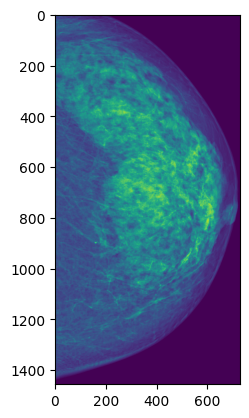

In [12]:
plt.imshow(next(iter(dataset))[0].numpy())

In [13]:
import keras
@keras.saving.register_keras_serializable()
class pFBeta(tf.keras.Metric):
    def __init__(self, beta=1, name='pF1', **kwargs):
        super().__init__(name=name, **kwargs)
        self.beta = beta
        self.epsilon = 1e-10
        self.pos = self.add_weight(name='pos', initializer='zeros')
        self.ctp = self.add_weight(name='ctp', initializer='zeros')
        self.cfp = self.add_weight(name='cfp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.keras.ops.cast(y_true, tf.float32)
        y_pred = tf.keras.ops.clip(y_pred, 0, 1)
        pos = tf.keras.ops.cast(tf.keras.ops.sum(y_true), tf.float32)
        ctp = tf.keras.ops.cast(tf.keras.ops.sum(y_pred[y_true == 1]), tf.float32)
        cfp = tf.keras.ops.cast(tf.keras.ops.sum(y_pred[y_true == 0]), tf.float32)
        self.pos.assign_add(pos)
        self.ctp.assign_add(ctp)
        self.cfp.assign_add(cfp)

    def result(self):
        beta2 = self.beta * self.beta
        prec = self.ctp / (self.ctp + self.cfp + self.epsilon)
        reca = self.ctp / (self.pos + self.epsilon)
        return (1 + beta2) * prec * reca / ((beta2 * prec + reca) + self.epsilon) 
    
    def reset_state(self):
        self.pos.assign(0.)
        self.ctp.assign(0.)
        self.cfp.assign(0.)
    
    def get_config(self):
        return {"beta": self.beta, "name": self.name}

In [14]:
model = tf.keras.models.load_model("/kaggle/input/rsna_model/keras/default/1/rsna_model_v7.keras")
history = model.predict(dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


In [15]:
test_csv = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/test.csv")
test_csv["prediction_id"] = test_csv["patient_id"].astype(str) + "_" + test_csv["laterality"].astype(str)

submission = pd.DataFrame()
submission["prediction_id"] = test_csv['prediction_id']
submission["cancer"] = history[:,0]
submission = submission.groupby('prediction_id').max() #.mean() #
submission = submission.sort_index()
submission.to_csv('submission.csv', index=True) # true or false depend on df
submission.head()


,cancer
prediction_id,
10008_L,1.0
10008_R,1.0
